In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [37]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [38]:
rand_sub_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 26

In [39]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [40]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [41]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [42]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [43]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

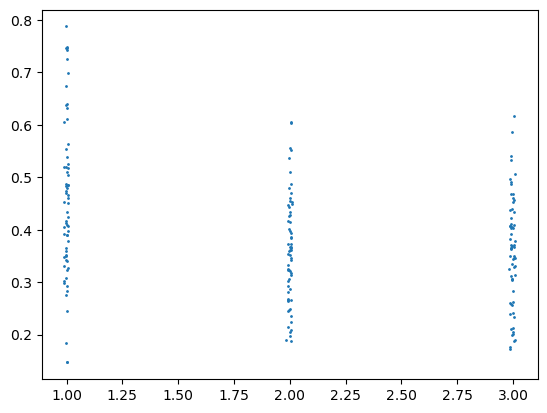

In [44]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [45]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [46]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(194, 3)


In [47]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [48]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [49]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 102.97it/s]


Loss: 1229.5476406309754
Average Loss: 0.16824680358935076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.38it/s]


Loss: 453.16506236139685
Average Loss: 0.062009450241023105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.63it/s]


Loss: 449.9120698836632
Average Loss: 0.06156432264417942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.92it/s]


Loss: 448.4550839024596
Average Loss: 0.06136495400964143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.86it/s]


Loss: 448.8498226972297
Average Loss: 0.0614189686230473
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.78it/s]


Loss: 448.80359332216904
Average Loss: 0.06141264276439095
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.73it/s]


Loss: 448.1123209968209
Average Loss: 0.061318051586866575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.81it/s]


Loss: 448.289462454617
Average Loss: 0.06134229097627491
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.47it/s]


Loss: 446.86059743119404
Average Loss: 0.06114677031078189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.71it/s]


Loss: 446.6512399096973
Average Loss: 0.0611181225930073
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▋                                                                                                                                                           | 124/7308 [00:04<01:07, 106.66it/s]

X_batch: 
torch.Size([128, 194])
tensor([[0.1279, 0.0572, 0.0596,  ..., 0.1813, 0.0746, 0.0462],
        [0.4679, 0.4064, 0.3333,  ..., 0.5750, 0.3249, 0.2695],
        [0.4327, 0.3666, 0.2362,  ..., 0.2725, 0.4332, 0.4340],
        ...,
        [0.4815, 0.3107, 0.2100,  ..., 0.4998, 0.2634, 0.3552],
        [0.4159, 0.2299, 0.2481,  ..., 0.6884, 0.1530, 0.4744],
        [0.4831, 0.1942, 0.2138,  ..., 0.5208, 0.3065, 0.2092]])
X_pred: 
torch.Size([128, 194])
tensor([[0.1496, 0.0593, 0.0030,  ..., 0.1419, 0.0384, 0.0031],
        [0.5675, 0.3618, 0.1862,  ..., 0.5583, 0.3449, 0.1874],
        [0.4344, 0.2705, 0.0839,  ..., 0.4179, 0.2316, 0.0849],
        ...,
        [0.5345, 0.3353, 0.1562,  ..., 0.5235, 0.3134, 0.1573],
        [0.5666, 0.3542, 0.1847,  ..., 0.5588, 0.3388, 0.1859],
        [0.4818, 0.2406, 0.1105,  ..., 0.4767, 0.2369, 0.1113]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.19it/s]


Loss: 446.1279016966
Average Loss: 0.06104651090539136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.50it/s]


Loss: 446.0296762259677
Average Loss: 0.061033070091128586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.10it/s]


Loss: 445.2481179260649
Average Loss: 0.06092612451095578
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.60it/s]


Loss: 445.1256563072093
Average Loss: 0.060909367310783974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.71it/s]


Loss: 444.3774306322448
Average Loss: 0.060806982845134756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.61it/s]


Loss: 443.3672877973877
Average Loss: 0.06066875859296493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.01it/s]


Loss: 442.30044776713476
Average Loss: 0.06052277610387723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.64it/s]


Loss: 442.14976103557274
Average Loss: 0.06050215668248122
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.61it/s]


Loss: 441.0341955916956
Average Loss: 0.060349506785946305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.59it/s]


Loss: 441.94836878217757
Average Loss: 0.06047459890287049
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.68it/s]


Loss: 441.0319288354367
Average Loss: 0.06034919661130771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.11it/s]


Loss: 441.4055578787811
Average Loss: 0.060400322643511375
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.39it/s]


Loss: 440.76262235688046
Average Loss: 0.060312345697438485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.72it/s]


Loss: 440.6381497681141
Average Loss: 0.060295313323496726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.03it/s]


Loss: 439.93892520014197
Average Loss: 0.06019963399016721
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 98.38it/s]


Loss: 440.4226767066866
Average Loss: 0.060265828777598056
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.21it/s]


Loss: 438.9175678337924
Average Loss: 0.060059875182511276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.57it/s]


Loss: 439.1450561657548
Average Loss: 0.06009100385409891
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.68it/s]


Loss: 438.8628126438707
Average Loss: 0.06005238268252199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.71it/s]


Loss: 438.72989513585344
Average Loss: 0.06003419473670682
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.67it/s]


Loss: 438.4100866005756
Average Loss: 0.059990433306044824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.24it/s]


Loss: 437.2978860391304
Average Loss: 0.05983824384771899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.28it/s]


Loss: 437.33134319866076
Average Loss: 0.059842822003100815
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.36it/s]


Loss: 436.832068326883
Average Loss: 0.05977450305512904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.63it/s]


Loss: 436.27298432122916
Average Loss: 0.059698000043955826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.70it/s]


Loss: 435.9237482449971
Average Loss: 0.05965021185618461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.40it/s]


Loss: 435.1095061758533
Average Loss: 0.05953879394852946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.50it/s]


Loss: 434.78830426745117
Average Loss: 0.05949484185378368
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.26it/s]


Loss: 434.18989289412275
Average Loss: 0.05941295742940925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.13it/s]


Loss: 433.3030115268193
Average Loss: 0.05929159982578261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.15it/s]


Loss: 433.2115383129567
Average Loss: 0.05927908296564815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.20it/s]


Loss: 432.9286965345964
Average Loss: 0.05924037993084242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.09it/s]


Loss: 432.2039789748378
Average Loss: 0.05914121222972603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.31it/s]


Loss: 432.41430324455723
Average Loss: 0.059169992233792726
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.18it/s]


Loss: 432.2069360767491
Average Loss: 0.059141616868739616
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.96it/s]


Loss: 431.43651328375563
Average Loss: 0.059036195030617904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.72it/s]


Loss: 431.25387352798134
Average Loss: 0.05901120327421748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.62it/s]


Loss: 431.0419059013948
Average Loss: 0.05898219839920563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.18it/s]


Loss: 430.75067646149546
Average Loss: 0.058942347627462435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.34it/s]


Loss: 430.7240011356771
Average Loss: 0.05893869747340957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.25it/s]


Loss: 430.4553311173804
Average Loss: 0.058901933650435195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.34it/s]


Loss: 430.2728743394837
Average Loss: 0.05887696693205852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.62it/s]


Loss: 430.2477684542537
Average Loss: 0.05887353153451747
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.47it/s]


Loss: 429.965382498689
Average Loss: 0.05883489087283648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.30it/s]


Loss: 429.74007192021236
Average Loss: 0.05880406019707339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.15it/s]


Loss: 429.22704690601677
Average Loss: 0.05873385972988735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.65it/s]


Loss: 429.5283489404246
Average Loss: 0.05877508879863501
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.30it/s]


Loss: 428.59005244029686
Average Loss: 0.05864669573622015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.75it/s]


Loss: 429.079457486514
Average Loss: 0.058713664133348935
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.08it/s]


Loss: 427.623501076363
Average Loss: 0.0585144363815494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.34it/s]


Loss: 428.2174093318172
Average Loss: 0.05859570461573853
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.26it/s]


Loss: 427.6430394798517
Average Loss: 0.05851710994524517
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.08it/s]


Loss: 427.6128757088445
Average Loss: 0.05851298244510735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.22it/s]


Loss: 427.54049832141027
Average Loss: 0.05850307858804191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.48it/s]


Loss: 426.6223971960135
Average Loss: 0.05837744898686555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.24it/s]


Loss: 426.9493652358651
Average Loss: 0.058422190097956364
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.41it/s]


Loss: 426.76501432526857
Average Loss: 0.058396964193386504
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.70it/s]


Loss: 426.5121290385723
Average Loss: 0.058362360295371146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.73it/s]


Loss: 426.45719991484657
Average Loss: 0.05835484399491606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.42it/s]


Loss: 426.3907549199648
Average Loss: 0.05834575190475709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.61it/s]


Loss: 426.5892092268914
Average Loss: 0.05837290766651497
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.22it/s]


Loss: 426.23161306465045
Average Loss: 0.058323975515141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.16it/s]


Loss: 425.7783711454831
Average Loss: 0.05826195554809566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.93it/s]


Loss: 425.6030416013673
Average Loss: 0.0582379640943305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.29it/s]


Loss: 425.4199296468869
Average Loss: 0.058212907723985616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.50it/s]


Loss: 425.5904068555683
Average Loss: 0.05823623520191137
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.70it/s]


Loss: 425.06165414489806
Average Loss: 0.0581638826142444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.26it/s]


Loss: 424.76193840336055
Average Loss: 0.05812287060801321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.68it/s]


Loss: 424.88258130894974
Average Loss: 0.058139378942111346
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.97it/s]


Loss: 424.5488104163669
Average Loss: 0.05809370695352585
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.02it/s]


Loss: 424.6830019732006
Average Loss: 0.0581120692355228
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.81it/s]


Loss: 424.8052436565049
Average Loss: 0.05812879634051791
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.42it/s]


Loss: 424.59149954328313
Average Loss: 0.05809954837757021
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.19it/s]


Loss: 424.73796827113256
Average Loss: 0.05811959062276034
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.87it/s]


Loss: 424.2870854525827
Average Loss: 0.058057893466417994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.69it/s]


Loss: 424.1975360326469
Average Loss: 0.05804563985121058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.15it/s]


Loss: 424.6705761924386
Average Loss: 0.0581103689371153
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 123.90it/s]


Loss: 424.19487467454746
Average Loss: 0.058045275680698886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.01it/s]


Loss: 424.0133711723611
Average Loss: 0.058020439405084986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.71it/s]


Loss: 423.9632297507487
Average Loss: 0.05801357823628198
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.91it/s]


Loss: 423.905001134146
Average Loss: 0.05800561044528544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 88.04it/s]


Loss: 424.1446922146715
Average Loss: 0.05803840889636994
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.47it/s]


Loss: 423.5128091527149
Average Loss: 0.05795194432850505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:48<00:00, 67.55it/s]


Loss: 423.8703538137488
Average Loss: 0.05800086943264215
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.10it/s]


Loss: 423.5509308469482
Average Loss: 0.057957160761760836
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.70it/s]


Loss: 423.64373532589525
Average Loss: 0.05796985978734199
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.42it/s]


Loss: 424.1062196949497
Average Loss: 0.058033144457437014
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.15it/s]


Loss: 423.53449253086
Average Loss: 0.057954911402690205
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.03it/s]


Loss: 423.35644217347726
Average Loss: 0.057930547642785615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.78it/s]


Loss: 423.51343239750713
Average Loss: 0.05795202961104367
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.18it/s]


Loss: 423.54987046914175
Average Loss: 0.05795701566353883
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.80it/s]


Loss: 423.3973810733296
Average Loss: 0.057936149572157855
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.34it/s]


Loss: 423.2304075807333
Average Loss: 0.05791330152993066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.81it/s]


Loss: 423.22227019863203
Average Loss: 0.05791218804031637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.42it/s]


Loss: 423.21318458300084
Average Loss: 0.057910944797892834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.94it/s]


Loss: 423.2365404483862
Average Loss: 0.05791414072911689
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.88it/s]


Loss: 423.0277588972822
Average Loss: 0.05788557182502493
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.44it/s]


Loss: 423.2630745708011
Average Loss: 0.057917771561412305
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.16it/s]


Loss: 422.9271756950766
Average Loss: 0.05787180838739417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.89it/s]


Loss: 423.21894365921617
Average Loss: 0.05791173284882542
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.65it/s]


Loss: 423.257973149186
Average Loss: 0.05791707350153065
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.75it/s]


Loss: 422.7278193985112
Average Loss: 0.05784452920067203
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.38it/s]


Loss: 423.18563269637525
Average Loss: 0.05790717469846405
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.25it/s]


Loss: 421.72295588068664
Average Loss: 0.057707027350942346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.97it/s]


Loss: 407.01782685611397
Average Loss: 0.05569483126109934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.87it/s]


Loss: 402.104219581699
Average Loss: 0.05502247120712904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.98it/s]


Loss: 400.59889500867575
Average Loss: 0.05481648809642525
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.34it/s]


Loss: 400.5953594474122
Average Loss: 0.0548160043031489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.11it/s]


Loss: 400.4328192353714
Average Loss: 0.054793762894823676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 116.00it/s]


Loss: 399.8642075697426
Average Loss: 0.05471595615349515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.11it/s]


Loss: 399.73994861450046
Average Loss: 0.054698953012383755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.61it/s]


Loss: 399.63562396145426
Average Loss: 0.05468467760829971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.87it/s]


Loss: 399.7410494403448
Average Loss: 0.054699103645367377
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.57it/s]


Loss: 399.4296001761686
Average Loss: 0.05465648606679921
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.94it/s]


Loss: 399.32131948438473
Average Loss: 0.054641669332838635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.81it/s]


Loss: 399.1047222139314
Average Loss: 0.05461203095428727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 102.98it/s]


Loss: 399.32705105585046
Average Loss: 0.05464245362012185
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.08it/s]


Loss: 399.2198529918678
Average Loss: 0.05462778502899122
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [02:33<00:00, 47.66it/s]


Loss: 399.04293907852843
Average Loss: 0.05460357677593438
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [03:03<00:00, 39.79it/s]


Loss: 399.10214835079387
Average Loss: 0.05461167875626627
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [07:16<00:00, 16.72it/s]


Loss: 399.156630292302
Average Loss: 0.05461913386594171
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.14it/s]


Loss: 399.0808240415063
Average Loss: 0.05460876081575072
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.44it/s]


Loss: 399.04893248178996
Average Loss: 0.0546043968913232
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.43it/s]


Loss: 398.86504760803655
Average Loss: 0.054579234757531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.43it/s]


Loss: 398.92709651822224
Average Loss: 0.054587725303533424
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.71it/s]


Loss: 399.00144342519343
Average Loss: 0.05459789866245121
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.69it/s]


Loss: 398.7891125094611
Average Loss: 0.05456884407628094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.38it/s]


Loss: 398.6812197016552
Average Loss: 0.0545540804189457
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.22it/s]


Loss: 398.80314877210185
Average Loss: 0.05457076474714037
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.91it/s]


Loss: 398.99682364892215
Average Loss: 0.05459726650915738
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.41it/s]


Loss: 398.64295806665905
Average Loss: 0.054548844836707584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.85it/s]


Loss: 398.57252527051605
Average Loss: 0.054539207070404494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.62it/s]


Loss: 398.73836072394624
Average Loss: 0.05456189938751317
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.89it/s]


Loss: 398.6177392497193
Average Loss: 0.05454539398600428
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.57it/s]


Loss: 398.5519103889819
Average Loss: 0.05453638620538888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.43it/s]


Loss: 398.48327667056583
Average Loss: 0.05452699461830403
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.20it/s]


Loss: 398.36308752628975
Average Loss: 0.054510548375244904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.01it/s]


Loss: 398.45838214154355
Average Loss: 0.05452358814197367
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.39it/s]


Loss: 398.4683985717129
Average Loss: 0.054524958753655296
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.71it/s]


Loss: 398.38198927324265
Average Loss: 0.0545131348211881
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.89it/s]


Loss: 398.45777278766036
Average Loss: 0.05452350476021625
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.30it/s]


Loss: 398.2302007121034
Average Loss: 0.05449236462946133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.70it/s]


Loss: 398.4242629809305
Average Loss: 0.05451891940078414
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.05it/s]


Loss: 398.18308572960086
Average Loss: 0.054485917587520645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.29it/s]


Loss: 398.1895411934238
Average Loss: 0.05448680092958727
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.21it/s]


Loss: 398.2080724260304
Average Loss: 0.05448933667570203
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.36it/s]


Loss: 398.3063827564474
Average Loss: 0.05450278910186746
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.16it/s]


Loss: 398.20993071538396
Average Loss: 0.054489590957222764
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.09it/s]


Loss: 398.1857344750315
Average Loss: 0.05448628003216085
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.13it/s]


Loss: 398.22146989009343
Average Loss: 0.054491169935699704
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.48it/s]


Loss: 398.15452064410783
Average Loss: 0.05448200884566336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.93it/s]


Loss: 397.9778976382222
Average Loss: 0.054457840399318856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.13it/s]


Loss: 397.99337612790987
Average Loss: 0.054459958419254224
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.07it/s]


Loss: 398.0678891495336
Average Loss: 0.054470154508693705
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.29it/s]


Loss: 398.0475044802297
Average Loss: 0.05446736514507795
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.50it/s]


Loss: 398.04724447452463
Average Loss: 0.054467329566847925
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.81it/s]


Loss: 398.0753061200958
Average Loss: 0.054471169419827006
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.55it/s]


Loss: 398.0569648919627
Average Loss: 0.05446865967322971
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.21it/s]


Loss: 398.09017326007597
Average Loss: 0.05447320378490366
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.68it/s]


Loss: 397.9143366103526
Average Loss: 0.05444914294066128
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.07it/s]


Loss: 397.95742923323996
Average Loss: 0.05445503957761904
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.84it/s]


Loss: 397.99017684115097
Average Loss: 0.05445952064055158
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.65it/s]


Loss: 397.90121992095374
Average Loss: 0.054447348100842057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.69it/s]


Loss: 397.8793477755971
Average Loss: 0.05444435519644186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.16it/s]


Loss: 397.75907227164134
Average Loss: 0.05442789713623992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.01it/s]


Loss: 397.83508614776656
Average Loss: 0.05443829859712186
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.61it/s]


Loss: 397.92883628443815
Average Loss: 0.05445112702304846
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.30it/s]


Loss: 397.8055313748773
Average Loss: 0.05443425443005984
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.20it/s]


Loss: 397.8030954678543
Average Loss: 0.054433921109449133
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.47it/s]


Loss: 397.8733419396449
Average Loss: 0.054443533379809096
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.73it/s]


Loss: 397.72959059104323
Average Loss: 0.05442386297085978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.83it/s]


Loss: 397.74294981593266
Average Loss: 0.05442569099834875
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.33it/s]


Loss: 397.7654011333361
Average Loss: 0.054428763154534224
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.41it/s]


Loss: 397.83464775863104
Average Loss: 0.05443823860955543
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.62it/s]


Loss: 397.8505082053598
Average Loss: 0.05444040889509576
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.76it/s]


Loss: 397.6666151005775
Average Loss: 0.05441524563499965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.67it/s]


Loss: 397.77227553050034
Average Loss: 0.054429703821907545
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.83it/s]


Loss: 397.6978819547221
Average Loss: 0.05441952407700083
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.52it/s]


Loss: 397.7103831039276
Average Loss: 0.05442123468855058
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.99it/s]


Loss: 397.67617998388596
Average Loss: 0.05441655445865982
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.98it/s]


Loss: 397.5708148838021
Average Loss: 0.05440213668360729
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.61it/s]


Loss: 397.5677315404173
Average Loss: 0.05440171477017204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.83it/s]


Loss: 397.61849829298444
Average Loss: 0.05440866150697653
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.58it/s]


Loss: 397.5909372565802
Average Loss: 0.05440489015552548
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.75it/s]


Loss: 397.672646808438
Average Loss: 0.05441607099184975
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.68it/s]


Loss: 397.68396865413524
Average Loss: 0.05441762023181927
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.62it/s]


Loss: 397.75967148086056
Average Loss: 0.054427979129838606
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.42it/s]


Loss: 397.5599985551089
Average Loss: 0.054400656616736306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.81it/s]


Loss: 397.63328523701057
Average Loss: 0.05441068489833204
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.21it/s]


Loss: 397.49815807538107
Average Loss: 0.05439219459159566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.44it/s]


Loss: 397.6666243961081
Average Loss: 0.05441524690696608
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.64it/s]


Loss: 397.5073806659784
Average Loss: 0.05439345657717275
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.21it/s]


Loss: 397.64480133820325
Average Loss: 0.05441226071951331
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.74it/s]


Loss: 397.5716644937638
Average Loss: 0.054402252941128056
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.47it/s]


Loss: 397.52413919591345
Average Loss: 0.054395749753135395
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.43it/s]


Loss: 397.49905460327864
Average Loss: 0.05439231726919522
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.49it/s]


Loss: 397.4911781619303
Average Loss: 0.05439123948575948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.91it/s]


Loss: 397.4691447133664
Average Loss: 0.054388224509218173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.58it/s]


Loss: 397.5169116125908
Average Loss: 0.05439476075705949
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.08it/s]


Loss: 397.45405866694637
Average Loss: 0.05438616018978467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.38it/s]


Loss: 397.3846606335137
Average Loss: 0.05437666401662749
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.73it/s]


Loss: 397.5700742097106
Average Loss: 0.05440203533247271
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.43it/s]


Loss: 397.56680513964966
Average Loss: 0.05440158800487817
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.33it/s]


Loss: 397.38957509049214
Average Loss: 0.05437733649295185
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.91it/s]


Loss: 397.35344128962606
Average Loss: 0.054372392075756164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.81it/s]


Loss: 397.4774468606338
Average Loss: 0.05438936054469538
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.80it/s]


Loss: 397.4080813797191
Average Loss: 0.05437986882590573
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.31it/s]


Loss: 397.390904533444
Average Loss: 0.05437751840906458
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.50it/s]


Loss: 397.4678476485424
Average Loss: 0.05438804702361007
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.63it/s]


Loss: 397.4130753565114
Average Loss: 0.05438055218343068
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.49it/s]


Loss: 397.41069591464475
Average Loss: 0.05438022658930552
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.06it/s]


Loss: 397.38624391844496
Average Loss: 0.054376880667548574
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.69it/s]


Loss: 397.42889080545865
Average Loss: 0.054382716311639115
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.53it/s]


Loss: 397.4705179273151
Average Loss: 0.05438841241479407
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.12it/s]

Loss: 397.4884920923505
Average Loss: 0.05439087193381917
Done, best loss: 397.35344128962606
Done


<All keys matched successfully>

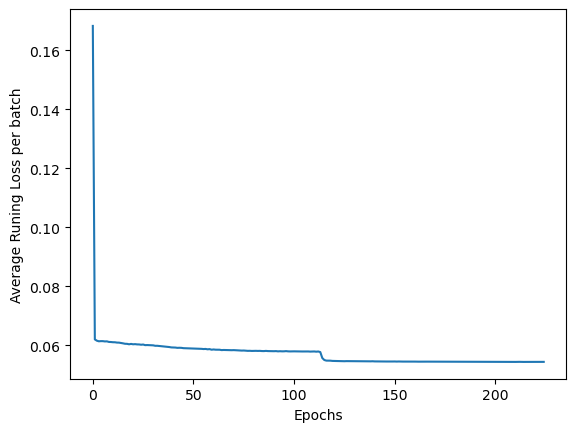

In [50]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [51]:
torch.save(final_model, 'model_100206_13g_04.pt')